# 08. Vision Transformer

Reference Video: https://www.udemy.com/course/pytorch-for-deep-learning/learn/lecture/33975292#overview

Reference Book: https://www.learnpytorch.io/08_pytorch_paper_replicating/

Extra curricular Reference: [Making Deep Learning Go Brrrr From First Principles](https://horace.io/brrr_intro.html)

In [1]:
import torch
import torchvision
from torch import nn

print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.0.1+cu117
torchvision version: 0.15.2+cu117


In [2]:
import matplotlib.pyplot as plt
from torchinfo import summary
from going_modular import data_setup, engine, utils
from helper_functions import set_seeds

/home/kpatel2s/miniconda3/envs/pytorch_practice/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda


In [4]:
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### Create data loaders

In [5]:
from torchvision import datasets, transforms
import os
from going_modular import data_setup

IMG_SIZE = 224

manual_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

manual_transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)

In [ ]:
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                test_dir=test_dir,
                                                                                transform=manual_transform,
                                                                                batch_size=BATCH_SIZE,
                                                                                num_workers=NUM_WORKERS)

print(f"train_dataloader: {train_dataloader}")
print(f"test_dataloader: {test_dataloader}")
print(f"class_names: {class_names}")

### Sample from a dataset

In [ ]:
# import random
# # Visualize random 9 images in 3x3 grid
# for i in range(9):
#     plt.subplot(3, 3, i+1)
#     idx = random.randint(0, len(train_dataloader.dataset))
#     plt.imshow(train_dataloader.dataset[idx][0].permute(1, 2, 0))
#     plt.title(f"Label: {class_names[train_dataloader.dataset[idx][1]]}")
#     plt.axis("off")

# get a single image
img_batch, label_batch = next(iter(train_dataloader))
img, label = img_batch[0], label_batch[0]
print(f"img.shape: {img.shape}, label: {label}")

# visualize
img = img.permute(1, 2, 0)
plt.imshow(img)


### Replicating ViT: Overview

- Inputs - Here, image
- Outputs - classification label
- Layers - manipulate with functions
- Blocks - collection of layers
- Models - collection of blocks

### ViT Figures and Equations

#### Main Figure
<img src="https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-figure-1-architecture-overview.png?raw=true" width="900">
<br></br>

#### Four Equations

<img src="https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-four-equations.png?raw=true" width="900">
<br></br>

#### Table

<img src="https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-table-1.png?raw=true" width="900">

### Equation 1 - Convert image to patches

- Input shape: $H \times W \times C$ (height $\times$ width $\times$ color channels)
- Output shape: $N \times\left(P^2 \cdot C\right)$
- $\mathrm{H}=$ height
- $\mathrm{W}=$ width
- $\mathrm{C}=$ color channels
- $\mathrm{P}=$ patch size
- $\mathrm{N}=$ number of patches $=\left(\right.$ height ${ }^*$ width $) / \mathrm{p}^{\wedge} 2$
- $\mathrm{D}=$ constant latent vector size $=$ embedding dimension (see Table 1) $\left(P^2 \cdot C\right)$


In [ ]:
height, width, channels = 224, 224, 3
patch_size = 16

# Number of patches
num_patches = int(height * width / patch_size ** 2)
num_patches

In [ ]:
embedding_layer_input_shape = (height, width, channels)

embedding_layer_output_shape = (num_patches, patch_size ** 2 * channels)

print(f"embedding_later_input_shape (single 2D image): {embedding_layer_input_shape}")
print(f"embedding_later_output_shape (single 1D sequence of patches): {embedding_layer_output_shape}")

In [ ]:
plt.imshow(img)
img.shape

In [ ]:
# Image must be divisible by patch size

img_size = 224

fig, axes = plt.subplots(nrows = int(img_size/patch_size),
                         ncols = int(img_size/patch_size),
                         sharex=True,
                         sharey=True,
                         figsize=(patch_size, patch_size))

for i, patch in enumerate(range(0, img_size, patch_size)):
    for j, patch in enumerate(range(0, img_size, patch_size)):
        axes[i][j].imshow(img[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size, :])
        axes[i][j].set_xlabel(i * int(img_size/patch_size) + j+1)
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])

- ##### Perhaps we could create the image patches and image patch embeddings in a single step using `torch.nn.Conv2d()` and setting the kernel size and stride parameters to `patch_size`.

In [ ]:
from torch import nn

conv2d = nn.Conv2d(in_channels=3,
                   out_channels=patch_size ** 2 * channels, # N^2 * C
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0) 
conv2d

In [ ]:
# Pass the image through the convolutional layer
img_permuted = img.permute(2, 0, 1)
img_out_of_conv = conv2d(img_permuted.unsqueeze(0))
print(f"img_out_of_conv.shape: {img_out_of_conv.shape}")

### Visualize feature maps

In [ ]:
# plot random convolutional feature maps (embeddings)
import random
import numpy as np
random_indexes = random.sample(range(0, 758), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot 
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = img_out_of_conv[:, idx, :, :] # index on the output tensor of the conv2d layer
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # remove batch dimension, and remove from grad tracking/switch to numpy for matplotlib
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [ ]:
# Flatten the patch embeddings using nn.Flatten
flatten = nn.Flatten(start_dim=2)
img_patches_flattened = flatten(img_out_of_conv)
print(f"img_patches_flattened.shape: {img_patches_flattened.shape}")

In [ ]:
print(f"img_patches_flattened (batch_size, num_patches, embedding dimension): {img_patches_flattened.permute(0, 2, 1).shape}")

### Patch embedding as single code block

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, input_channels, embedding_size, patch_size):
        super().__init__()
        self.input_channels = input_channels
        self.embedding_size = embedding_size
        self.patch_size = patch_size
        self.projection = nn.Conv2d(in_channels=self.input_channels,
                                    out_channels=self.embedding_size,
                                    kernel_size=self.patch_size,
                                    stride=self.patch_size)
        
        self.flatten = nn.Flatten(start_dim=2)

    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Image resolution must be divisible by patch size"
        x = self.projection(x)
        x = self.flatten(x)
        return x.permute(0, 2, 1) # (batch_size, num_patches, embedding dimension)
    
embedding_layer = PatchEmbedding(input_channels=img.shape[-1],
                                 embedding_size=embedding_layer_output_shape[1],
                                 patch_size=patch_size)
embedding_layer

In [ ]:
print(f"Image shape: {img_permuted.unsqueeze(0).shape}")
patch_embedding = embedding_layer(img_permuted.unsqueeze(0))
print(f"patch_embedding.shape: {patch_embedding.shape}")



### Add a learnable class embedding

In [ ]:
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[2]
print(f"batch_size: {batch_size}, embedding_dimension: {embedding_dimension}")


In [ ]:
# Class token as a trainable parameter, so we are using nn.Parameter
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension),
                           requires_grad=True)
print(f"class_token.shape: {class_token.shape}")

In [ ]:
# Add class token to the front of the patch embeddings
patch_embedding_with_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"patch_embedding_with_class_token.shape: {patch_embedding_with_class_token.shape}")

### Add positional embedding (learnable)

In [ ]:
positional_embedding = nn.Parameter(torch.randn(1, num_patches+1, embedding_dimension),
                                    requires_grad=True)

# Add patch embeddings to positional embedding
patch_and_positional_embedding = patch_embedding_with_class_token + positional_embedding

print(f"patch_and_positional_embedding.shape: {patch_and_positional_embedding.shape}")
# NOTE: the shape remains the same as we are adding not concatenating, but values are changed

### Put everything together
Image -> Embeddings

In [ ]:
set_seeds(seed=42)

patch_size = 16

print('Image shape: ', img.permute(2, 1, 0).shape)

# Add batch dimension
x = img.permute(2, 1, 0).unsqueeze(0)
print('Input image shape: ', x.shape)

# Patch embedding
patch_embedding_layer = PatchEmbedding(input_channels=x.shape[1],
                                        embedding_size=patch_size ** 2 * x.shape[1],
                                        patch_size=patch_size)

patch_embedding = patch_embedding_layer(x)
print('Patch embedding shape: ', patch_embedding.shape)

# Add class token
class_token = nn.Parameter(torch.randn(batch_size, 1, patch_embedding.shape[-1]),
                           requires_grad=True)

print('Class token shape: ', class_token.shape)

patch_embedding_with_class_token = torch.cat((class_token, patch_embedding), dim=1)
print('Patch embedding with class token shape: ', patch_embedding_with_class_token.shape)

# Add positional embedding
positional_embedding = nn.Parameter(torch.randn(1, num_patches+1, patch_embedding.shape[-1]),
                                    requires_grad=True)

patch_and_positional_embedding = patch_embedding_with_class_token + positional_embedding
print('Patch and positional embedding shape: ', patch_and_positional_embedding.shape)

### Put everything together in a single class

We are coding the `ImageEmbedding` block from the paper, as shown in the below diagram,

<img src="image-5.png" width="600">

This part represent the **First equation** from the paper,

\begin{aligned}
\mathbf{z}_0=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, \quad \mathbf{E} \in \mathbb{R}^{\left(P^2 \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D} \\
\end{aligned}

In [6]:
class ImageEmbedding(nn.Module):
    def __init__(self, 
                 input_channels: int=3, 
                 embedding_size: int=768, 
                 patch_size: int=16, 
                 batch_size: int=32,
                 embedding_dropout: float=0.1,
                 img_size: int=224):
        super().__init__()
        self.input_channels = input_channels
        self.embedding_size = embedding_size
        self.patch_size = patch_size
        self.batch_size = batch_size
        self.num_patches = int(img_size * img_size / patch_size ** 2)
        self.projection = nn.Conv2d(in_channels=self.input_channels,
                                    out_channels=self.embedding_size,
                                    kernel_size=self.patch_size,
                                    stride=self.patch_size).to(device)
        
        self.flatten = nn.Flatten(start_dim=2).to(device)

        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    def add_positional_embedding(self, x):
        # Add positional embedding
        positional_embedding = nn.Parameter(torch.randn(1, self.num_patches+1, self.embedding_size),
                                            requires_grad=True).to(device)
        patch_and_positional_embedding = x + positional_embedding
        return patch_and_positional_embedding

    def add_class_token(self, x):
        # Add class token
        class_token = nn.Parameter(torch.randn(self.batch_size, 1, self.embedding_size),
                                requires_grad=True).to(device)
        patch_embedding_with_class_token = torch.cat((class_token, x), dim=1)
        return patch_embedding_with_class_token

    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Image resolution must be divisible by patch size"
        x = self.projection(x)
        x = self.flatten(x)
        x = x.permute(0, 2, 1) # (batch_size, num_patches, embedding dimension)

        x = self.add_class_token(x)

        x = self.add_positional_embedding(x)

        x = self.embedding_dropout(x)

        return x
    
embedding_layer = ImageEmbedding(input_channels=3,
                                 embedding_size=768,
                                 patch_size=16,
                                 batch_size=32)
embedding_layer

ImageEmbedding(
  (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (flatten): Flatten(start_dim=2, end_dim=-1)
  (embedding_dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
# Image with 32 batches
x = torch.randn(32, 3, 224, 224).to(device)

# Image to embedding
embeddings = ImageEmbedding()
img_embeddings = embeddings(x).to(device)
print('Image embeddings shape: ', img_embeddings.shape)

### Multihead Self Attention (MSA)

We are coding the below block from the encoder,

<img src="image-2.png" width="200">

This represents the **Second equation** from the paper,

\begin{aligned}
\mathbf{z}_{\ell}^{\prime} & =\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \\
\end{aligned}


NOTE: we are using `Layer Normalization` instead of `Batch Normalization`

<img src="https://i.stack.imgur.com/fAowJ.png" width="800">

In [7]:
class MultiHeadAttentionBlock(nn.Module):
    def __init__(self, 
                  embedding_dimension:int=768,
                  num_heads:int=12,
                  attn_dropout:int = 0):
        super().__init__()
        self.layer_norm = nn.LayerNorm(embedding_dimension)
        self.multihead_attention = nn.MultiheadAttention(embed_dim=embedding_dimension,
                                                         num_heads=num_heads,
                                                         dropout=attn_dropout,
                                                         batch_first=True) # Is batch_first? (batch, seq, feature) -> (batch_size, number of patches, embedding dimension)

    def forward(self, x):
        x = self.layer_norm(x)
        attention_output, _ = self.multihead_attention(query=x,
                                                      key=x,
                                                      value=x,
                                                      need_weights=False)
        return attention_output

In [ ]:
msa = MultiHeadAttentionBlock(embedding_dimension=embedding_layer_output_shape[1],
                             num_heads=12,
                             attn_dropout=0)
attn_op = msa(img_embeddings)
attn_op.shape

### Multi-Layer Perceptron (MLP)

We are coding the below block from the encoder,

<img src="image-4.png" width="200">

This represents the **Third equation** from the paper (https://arxiv.org/abs/2010.11929),

- The MLP contains two layers with a GELU non-linearity,

<img src="https://cdn-images-1.medium.com/max/623/0*lpKy2FLJ8NV0QkGY" width="400">

\begin{aligned}
\mathbf{z}_{\ell} & =\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\
\mathbf{y} & =\operatorname{LN}\left(\mathbf{z}_L^0\right) & &
\end{aligned}

In [8]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, 
                  embedding_dimension:int=768,
                  mlp_size:int=3072, # Given in the paper Table 1
                  dropout:int = 0.1): # Given in the paper
        super().__init__()
        self.layer_norm = nn.LayerNorm(embedding_dimension)
        # The MLP contains two layers with a GELU non-linearity (from the paper)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dimension, out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(in_features=mlp_size, out_features=embedding_dimension),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [ ]:
mlp_block = MultiLayerPerceptron(embedding_dimension=embedding_layer_output_shape[1],
                                 mlp_size=3072,
                                 dropout=0.1)
mlp_op = mlp_block(attn_op)
mlp_op.shape

### Creating Encoder block for transformer

The encoder block is a combination of alternating blocks of Multihead Self Attention (MSA) and MLP.

We are coding the encoder block from the paper,

<img src="image-6.png" width="200">

In [9]:
class TransformerEncoder(nn.Module):
    def __init__(self, 
                  embedding_dimension:int=768,
                  num_heads:int=12,
                  mlp_size:int=3072,
                  mlp_dropout:int = 0.1,
                  attn_dropout:int = 0):
        super().__init__()

        self.msa_block = MultiHeadAttentionBlock(embedding_dimension=embedding_dimension,
                                                 num_heads=num_heads,
                                                 attn_dropout=attn_dropout)
        self.mlp_block = MultiLayerPerceptron(embedding_dimension=embedding_dimension,
                                              mlp_size=mlp_size,
                                              dropout=mlp_dropout)
        
    def forward(self, x):
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x
        return x

In [ ]:
transformer_encoder_block = TransformerEncoder()

# # Summary using torchinfo
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

### NOTE: PyTorch has Transformer Encoder block implemented in `torch.nn.TransformerEncoderLayer()`.

This is same as above but with PyTorch version, it is less prone to error and potentially better performance.

In [ ]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

torch_transformer_encoder_layer

In [ ]:
# Get the output of PyTorch's version of the Transformer Encoder (uncomment for full output)
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

### FINAL, Vision Transformer Model

In [10]:
class ViT(nn.Module):
    def __init__(self,
                img_size:int=224,# Table 3 from the ViT paper
                in_channels:int=3,
                patch_size:int=16,
                num_transformer_layers:int=12,
                embedding_dim:int=768,
                mlp_size:int=3072,
                num_heads:int=12,
                attn_dropout:int=0,
                mlp_dropout:int=0.1,
                embedding_dropout:int=0.1,
                num_classes:int=1000):
        
        super().__init__()

        # Check Image size is compatible with patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size"

        # Image embeddings
        self.image_embedding = ImageEmbedding(input_channels=in_channels,
                                              embedding_size=embedding_dim,
                                              patch_size=patch_size,
                                              batch_size=32,
                                              embedding_dropout=embedding_dropout)
                                              
        
        # Transformer Encoder Block
        self.transformer_encoder = nn.Sequential(*[TransformerEncoder(embedding_dimension=embedding_dim,
                                                                      num_heads=num_heads,
                                                                      mlp_size=mlp_size,
                                                                      mlp_dropout=mlp_dropout,
                                                                      attn_dropout=attn_dropout) for _ in range(num_transformer_layers)]).to(device)
        
        # MLP head
        self.classifier = nn.Sequential(
            nn.LayerNorm(embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        ).to(device)

    def forward(self, x):
        # Get the batch size
        batch_size = x.shape[0]

        # Image embeddings
        self.image_embedding.batch_size = batch_size
        x = self.image_embedding(x)

        # Transformer Encoder
        x = self.transformer_encoder(x)

        # MLP head
        # Put 0th index logit through the classifier (equation 4)
        x = self.classifier(x[:, 0])

        return x

In [ ]:
vit = ViT(num_classes=len(class_names))

# dummy image
img = torch.randn(1, 3, 224, 224).to(device)

# forward pass
op = vit(img).to(device)
op.shape

In [ ]:
# Get the output of PyTorch's version of the Transformer Encoder (uncomment for full output)
summary(model=vit,
        input_size=(1, 3, 224, 224), # (batch_size, channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

### Setting up Training Code

Frpom the section 4, Training and Fine-Tuning,
- Optimizer is Adam
    - $\beta1$ = 0.9
    - $\beta2$ = 0.99
    - weight decay = 0.1

In [ ]:
# Loss and Optimizer
loss_fn = nn.CrossEntropyLoss() # the paper didn't mention a loss function
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3,
                             weight_decay=0.1)

In [ ]:
from going_modular import engine

set_seeds(seed=42)

NUM_EPOCHS = 10

results = engine.train(model=vit,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS,
                      device=device)

In [ ]:
from helper_functions import plot_loss_curves
plot_loss_curves(results=results)

 ### Results

 The model trained from scratch is not performing well, as expected. Because our dataset is too small compare to the original paper (millions of images), the model is not able to learn the patterns.

 The next step is use transfer learning.

### Transfer learning with ViT

In [11]:
pretrained_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_weights).to(device)
pretrained_vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

#### Freeze the encoder layers

In [12]:
for param in pretrained_vit.encoder.parameters():
    param.requires_grad = False
for param in pretrained_vit.conv_proj.parameters():
    param.requires_grad = False

# Summary
summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224), # (batch_size, channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 1000]            768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [13]:
pretrained_vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [15]:
pretrained_vit.heads = nn.Sequential(
    nn.Linear(in_features=768, out_features=3)
)
pretrained_vit.heads

Sequential(
  (0): Linear(in_features=768, out_features=3, bias=True)
)

In [16]:
# Summary
summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224), # (batch_size, channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### Preprocess the data same as ViT

In [17]:
vit_transforms = pretrained_weights.transforms()
print(f"vit_transforms: {vit_transforms}")

vit_transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [18]:
# Setup dataloader
from going_modular import data_setup

NUM_WORKERS = os.cpu_count()

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=vit_transforms,
                                                                               batch_size=32,
                                                                               num_workers=NUM_WORKERS)
train_dataloader, test_dataloader, class_names

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )


(<torch.utils.data.dataloader.DataLoader at 0x7fd3d0235d10>,
 ['pizza', 'steak', 'sushi'])

In [21]:
from going_modular import engine, utils

set_seeds(seed=42)

NUM_EPOCHS = 10

# Loss and Optimizer
loss_fn = nn.CrossEntropyLoss() # the paper didn't mention a loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3,
                             weight_decay=0.1)

results = engine.train(model=pretrained_vit,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS,
                      device=device)

# Save the model
save_filename = "08_vit_b_16_10_epochs.pth"
utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="vit")

 10%|█         | 1/10 [00:04<00:37,  4.20s/it]

Epoch: 1 | train_loss: 0.7574 | train_acc: 0.7344 | test_loss: 0.5143 | test_acc: 0.8674


 20%|██        | 2/10 [00:08<00:32,  4.11s/it]

Epoch: 2 | train_loss: 0.3441 | train_acc: 0.9453 | test_loss: 0.3105 | test_acc: 0.9384


 30%|███       | 3/10 [00:12<00:28,  4.06s/it]

Epoch: 3 | train_loss: 0.1952 | train_acc: 0.9648 | test_loss: 0.2518 | test_acc: 0.9384


 40%|████      | 4/10 [00:16<00:24,  4.06s/it]

Epoch: 4 | train_loss: 0.1454 | train_acc: 0.9766 | test_loss: 0.2241 | test_acc: 0.9384


 50%|█████     | 5/10 [00:20<00:20,  4.07s/it]

Epoch: 5 | train_loss: 0.1156 | train_acc: 0.9766 | test_loss: 0.2139 | test_acc: 0.9384


 60%|██████    | 6/10 [00:24<00:16,  4.08s/it]

Epoch: 6 | train_loss: 0.1168 | train_acc: 0.9805 | test_loss: 0.2041 | test_acc: 0.9384


 70%|███████   | 7/10 [00:28<00:12,  4.09s/it]

Epoch: 7 | train_loss: 0.0889 | train_acc: 0.9805 | test_loss: 0.2312 | test_acc: 0.9186


 80%|████████  | 8/10 [00:32<00:08,  4.08s/it]

Epoch: 8 | train_loss: 0.0768 | train_acc: 0.9883 | test_loss: 0.2194 | test_acc: 0.9081


 90%|█████████ | 9/10 [00:36<00:04,  4.03s/it]

Epoch: 9 | train_loss: 0.1041 | train_acc: 0.9883 | test_loss: 0.1963 | test_acc: 0.9384


100%|██████████| 10/10 [00:40<00:00,  4.07s/it]

Epoch: 10 | train_loss: 0.0666 | train_acc: 0.9922 | test_loss: 0.1781 | test_acc: 0.9479


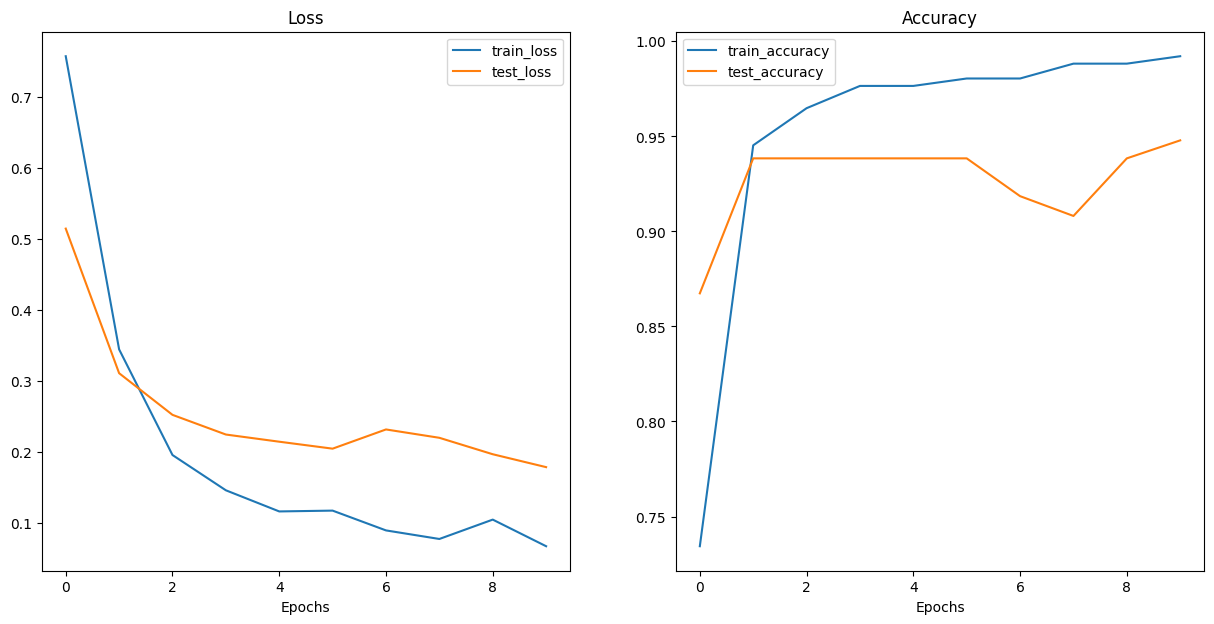

In [22]:
from helper_functions import plot_loss_curves
plot_loss_curves(results=results)

In [24]:
# Save the model
save_filename = "08_vit_b_16_10_epochs.pth"
utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name=save_filename)

[INFO] Saving model to: models/08_vit_b_16_10_epochs.pth


### Model Prediction using the best model

In [31]:
from typing import List, Tuple
from PIL import Image
from torchvision import transforms

def pred_and_plot_img(model,
                      img_path,
                      class_names,
                      img_size,
                      transform,
                      device):
    img = Image.open(img_path)

    if transform is not None:
        img_transform = transform
    else:
        img_transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    model.to(device)

    model.eval()
    
    with torch.inference_mode():
        img_tensor = img_transform(img).unsqueeze(0)
        img_tensor = img_tensor.to(device)
        prediction = model(img_tensor)

    pred_probs = torch.softmax(prediction, dim=1)
    pred_class = torch.argmax(pred_probs, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Prediction: {class_names[pred_class]} | Prob: {pred_probs.max():.3f}")

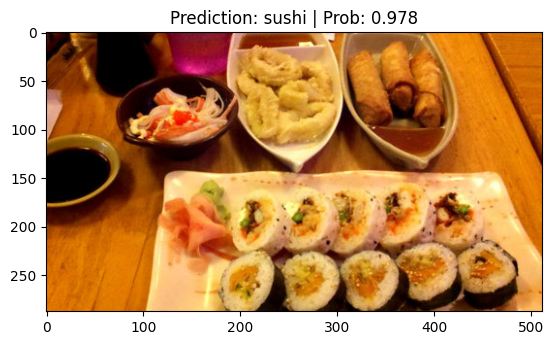

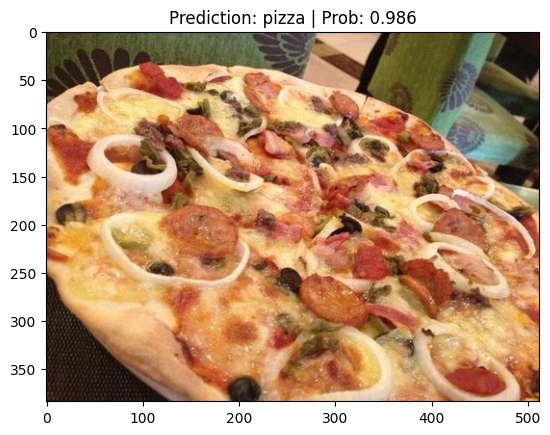

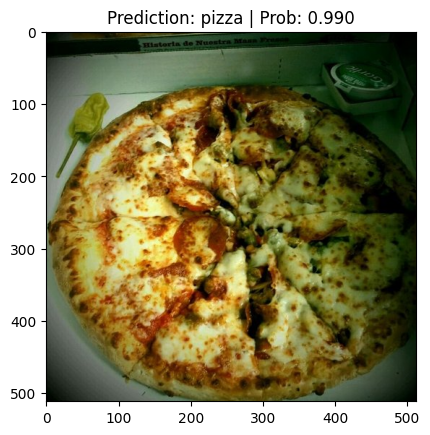

In [32]:
import random

num_imgs = 3
test_img_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_img_path_sample = random.sample(population=test_img_path_list, k=num_imgs)

for test_img in test_img_path_sample:
    pred_and_plot_img(model=pretrained_vit,
                    img_path=test_img,
                    class_names=class_names,
                    img_size=(224, 224),
                    transform=vit_transforms,
                    device=device)

### Result analysis

- ViT model and EfficientNet models are performing almost same on the test benchmark (94.67% vs 96%)
- ViT model is taking 11x more storage than EfficientNet (327 vs 30 MB)
- ViT has lower test loss compared to EfficientNet (0.1781 vs 0.2352), so ViT is likely to give higher confidence in predictions than EfficientNet

### Benchmark on testdata

In [25]:
def evaluate_model(model,
                   dataloader,
                   device):
    
    model.eval()

    test_accuracy = 0

    for batch, (X, y) in enumerate(dataloader):
        with torch.inference_mode():
            prediction = model(X.to(device)).to(device)
            test_accuracy += ((prediction.argmax(dim=1) == y.to(device)).sum().item())

    print(f"Test accuracy: {test_accuracy/len(dataloader) * 100:.2f} %")

In [28]:
from pathlib import Path
from torchvision import datasets, transforms
from going_modular import model_builder
import torch
import matplotlib.pyplot as plt

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

test_dir = image_path / "test"

# Create simple transform
data_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)

test_dataloader = torch.utils.data.DataLoader(test_data,
                                             batch_size=1,
                                             shuffle=False)

# Get class names as a list
class_names = test_data.classes

# device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# load the model architecture
model = torchvision.models.vit_b_16().to(device)
# Update the classifier head 
model.heads = nn.Sequential(
    nn.Linear(in_features=768, out_features=3)
).to(device)

# load the model weights
weights_file = "models/08_vit_b_16_10_epochs.pth"
model.load_state_dict(torch.load(weights_file))

evaluate_model(model=model, dataloader=test_dataloader, device=device)



Test accuracy: 94.67 %


### Check the model size (memory usage)

In [29]:
from pathlib import Path

pretrained_vit_model_size = Path("models/08_vit_b_16_10_epochs.pth").stat().st_size / 1024**2 # in MB
print(f"Pretrained ViT model size: {pretrained_vit_model_size:.2f} MB")

Pretrained ViT model size: 327.36 MB


In [30]:
# Previous efficient model
efficient_model_size = Path("models/07_efficientnet_b2_data_20_percent_10_epochs.pth").stat().st_size / 1024**2 # in MB
print(f"EfficientNet model size: {efficient_model_size:.2f} MB")

EfficientNet model size: 29.85 MB
